# Defining fuzzy logic system for evaluating TRS performance

<!-- ![load case](../images/TRS_example/load_case.png "Turbine rear structural thermal loads") -->

<p style="text-align:center;">
    <img src="../images/TRS_example/load_case.png" alt="load case" title="Turbine rear structural thermal loads" width="250px" align="center"/>
</p>

This example shows how to evaluate the design margins of a turbine rear structure (TRS) when experiencing thermal loads. Two temperatures affect the TRS' performance. They are the temperature of the nacelle compartment $T_1$ and the temperature of the gas surface $T_1$. The output that we are interested in is the safety factor $n_\textrm{safety}$.

Simulation results tell us that $n_\textrm{safety}$ decreases when the difference ${\lvert}T_2 - T_1{\rvert}$ and vice versa. Based on this qualitative knowledge, we can use ``dmLib`` to quantify these parameters and find out how much change can a TRS absorb.

## Define fuzzy parameters

First let us import all the required tools to define the parameters ``T1``, ``T2``, and ``n_safety`` as fuzzy parameters

In [60]:
from dmLib import triangularFunc, fuzzySet, fuzzyRule, fuzzySystem

Next we define the **universe** in which our parameters can vary. 
$$
250 \le T_1 \le 450 \\
480 \le T_2 \le 680 \\
1.0 \le n_\text{safety} \le 6.0 \\
$$

In [61]:
import numpy as np

# Generate universe variables
lb = np.array([250, 480, 1.0])
ub = np.array([450, 680, 6.0])
labels = ['T1','T2','n_safety']

universe = np.linspace(lb, ub, 100) # grid for all variables

Next, we define the **membership functions** in the form of a triangular function. The left foot of the triangle is given by ``shapes_lo``, the center of the triangle is given by ``shapes_md``, and the right foot of the triangle is given by ``shapes_hi``.

In [62]:
# Define shape of triangular membership functions
shapes_lo = np.array([lb,               lb,             lb + (ub-lb)/2  ])
shapes_md = np.array([lb + (ub-lb)/4,   lb + (ub-lb)/2, ub - (ub-lb)/4  ])
shapes_hi = np.array([lb + 1*(ub-lb)/2, ub,             ub              ])

Next we create fuzzy set object for each parameter by looping over ``lb``, ``ub``, and ``n_safety`` and visualize the results fuzzy sets.

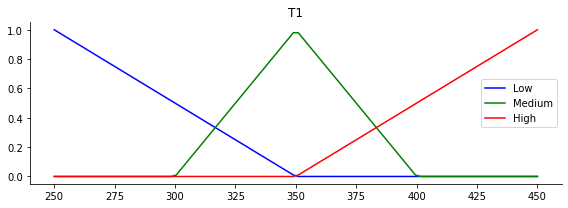

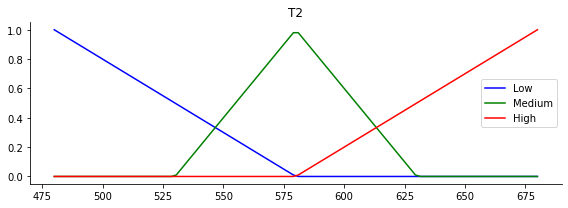

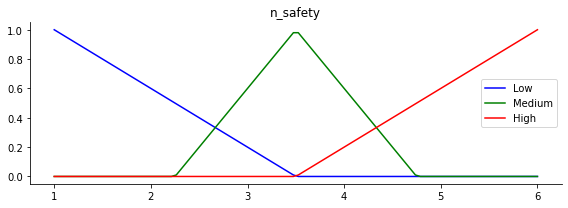

In [63]:
# Generate fuzzy membership functions
fuzzy_sets = []
for i in range(len(lb)):
    lo = triangularFunc(universe[:,i],labels[i])
    lo.setFunc(shapes_lo[0,i],shapes_lo[1,i],shapes_lo[2,i])

    md = triangularFunc(universe[:,i],labels[i])
    md.setFunc(shapes_md[0,i],shapes_md[1,i],shapes_md[2,i])

    hi = triangularFunc(universe[:,i],labels[i])
    hi.setFunc(shapes_hi[0,i],shapes_hi[1,i],shapes_hi[2,i])

    fuzzyset_i = fuzzySet(lo,md,hi,labels[i])

    fuzzy_sets += [fuzzyset_i]

# label each fuzzy set
temp_T1 = fuzzy_sets[0]
temp_T2 = fuzzy_sets[1]
n_safety = fuzzy_sets[2]

# Visualize these universes and membership functions
temp_T1.view()
temp_T2.view()
n_safety.view()

## Define fuzzy rules

Next we define the **fuzzy rules** needed to infer the value of ``n_safety``. The **antecedents** are ``T1`` and ``T2`` and the **consequent** is ``n_safety``.
The following fuzzy rules should be applied in our fuzzy logic system:

<table>
  <tr> <th>Rule</th><th>T1</th><th>Operator</th> <th>T2</th> <th>n_safety</th> </tr>
  <tr> <td>1</td> <td>low</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>2</td> <td>high</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>3</td> <td>low</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>4</td> <td>high</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>5</td> <td>medium</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>6</td> <td>medium</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>7</td> <td>low</td> <td>AND</td> <td>medium</td> <td>low</td> </tr>
  <tr> <td>8</td> <td>high</td> <td>AND</td> <td>medium</td> <td>high</td> </tr>
  <tr> <td>9</td> <td>medium</td> <td>AND</td> <td>medium</td> <td>medium</td> </tr>
</table>

In [64]:
# Define fuzzy rules
rule1 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R1')
rule2 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R2')
rule3 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.md,label='R3')
rule4 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.md,label='R4')

rule5 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R5')
rule6 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R6')
rule7 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.lo,label='R7')
rule8 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.hi,label='R8')

rule9 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.md,label='R9')

## Fuzzy inference on a single loadcase

Next we define our fuzzy logic system based on the **antecedents**, **consequents**, and **fuzzy rules** we have defined so far. We infer the value of ``n_safety`` based on ``T1=370`` and ``T2=580`` using the centroid rule for defuzzification (default). The outputs are the crisp value ``n_safety_value``, the aggregate membership function of the output ``aggregate``, and the activation function value at the centroid.

All of these outputs are displayed in the plot below.

In [65]:
# Define fuzzy control system
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
sim = fuzzySystem([temp_T1,temp_T2],n_safety,rules)

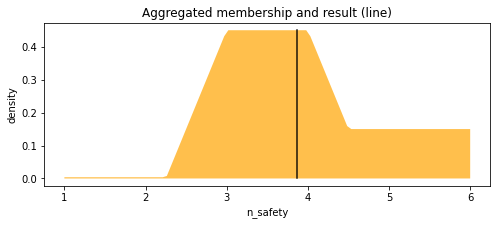

In [66]:
# Define inputs and compute the behaviour of the TRS at a given temperature
inputs = np.array([
    370.0, # T1
    580.0, # T2
    ])
n_safety_value, aggregate, n_safety_activation = sim.compute(inputs, normalize=True)

# Visualize the fuzzy behaviour
sim.view()

## Fuzzy inference on multiple combinations of loads (2D parameter space)

Next we infer the value of ``n_safety`` for different combinations of ``T1`` and ``T2`` by sweeping over them. We first create a 2D full factorial grid of the variables

In [67]:
from dmLib import Design

# Simulate at higher resolution the control space in 2D
n_levels = 20
inputs = Design(lb[:2],ub[:2],n_levels,"fullfact").unscale()

sim.reset() # remember to reset the fuzzy system when inferring a new set of values

Next, we retrieve the crisp values ``z`` for each of the samples in ``inputs``

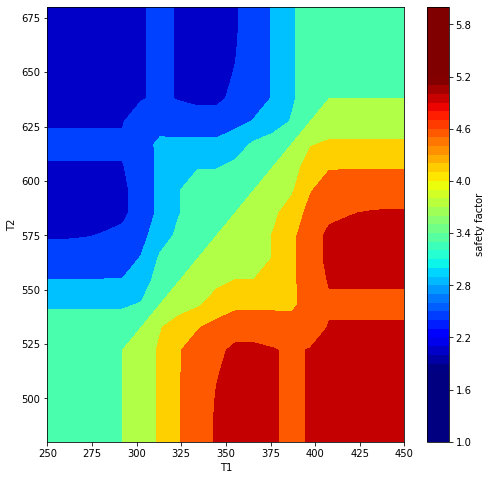

In [68]:
# Loop through the system to collect the control surface
z,a,_ = sim.compute(inputs)

# Reshape the outputs for contour plotting
x = inputs[:,0].reshape((n_levels,n_levels))
y = inputs[:,1].reshape((n_levels,n_levels))
z = z.reshape((n_levels,n_levels))

# Plot the result in 2D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

surf = ax.contourf(x, y, z, cmap=plt.cm.jet,)
ax.set_xlabel('T1')
ax.set_ylabel('T2')

cbar = plt.cm.ScalarMappable(cmap=plt.cm.jet)
cbar.set_array(z)

boundaries = np.linspace(1, 6, 51)
cbar_h = fig.colorbar(cbar, boundaries=boundaries)
cbar_h.set_label('safety factor', rotation=90, labelpad=3)

plt.show()

The expected inverse relationship between temperature difference and structural performance can be seen above

## Definition of uncertain requirements

### Requirement definition

The requirements are high level system specifications. In this examples they are given a Normal distribution in terms of $T_1$$ and $T_2$:

$$
T_1,T_2 \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

we define the means $\boldsymbol{\mu}$ and covariances $\boldsymbol{\Sigma}$ and use them to define a multivariate normal joint PDF

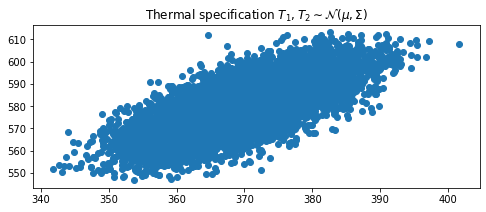

In [69]:
from dmLib import gaussianFunc # Import the Gaussian distribution class

# Requirement specifications for T1, T2
mu = np.array([370,580])
Sigma = np.array([
    [50, 25],
    [75, 100],
    ])
Requirement = gaussianFunc(mu, Sigma, 'R1')
Requirement(10000)
Requirement.view(xlabel='Thermal specification $T_1,T_2 \
    \sim \mathcal{N}(\mu,\Sigma)$')
Requirement.reset()

The samples from the distribution follow the expected distribution

### A requirement that is used as a target threshold

The target that the TRS must reach is a decided safety factor value that its own safety factor must exceed

$$
n_\textrm{safety} \ge n_\textrm{safety}^{decided}
$$

This $n_\textrm{safety}^{decided}$ is usually uncertain and can also be represented by a PDF centered around a mean

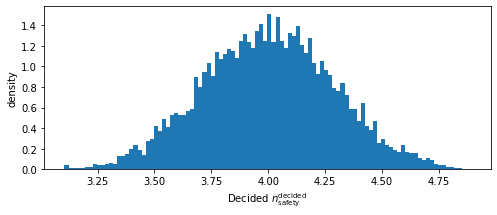

<Figure size 432x288 with 0 Axes>

In [70]:
# for n_decided
mu = np.array([4.0,])
Sigma = np.array([[0.3**2,],])
decided_safety = gaussianFunc(mu, Sigma, 'T1')
decided_safety(10000)
decided_safety.view(xlabel='Decided $n_\mathrm{safety}^\mathrm{decided}$',savefile='Th')
decided_safety.reset()

## Elements of Margin Analysis Network (MAN)

In this section we define the inputs and outputs needed to construct a MAN. We begin with the input specifications, which stem from design requirements.

In [71]:
from dmLib import InputSpec, Behaviour, MarginNode, MarginNetwork

### Input specifications
There are three input specifications in this example, $T_1$, $T_2$, and $n_\textrm{safety}^{decided}$

In [72]:
# define input specifications
s1 = InputSpec(Requirement.mu[0]    ,'S1'   ,cov_index=0    ,description='nacelle temperature'      ,symbol='T1'            ,distribution=Requirement   )
s2 = InputSpec(Requirement.mu[1]    ,'S2'   ,cov_index=1    ,description='gas surface temperature'  ,symbol='T2'            ,distribution=Requirement   )
s3 = InputSpec(decided_safety.mu    ,'S3'                   ,description='decided safety'           ,symbol='n_decided'                               )
input_specs = [s1,s2,s3]

### Behaviour

Finally,  the TRS own safety factor (governed by its behaviour) is given a simulation model or some other calculation. In this example it is given by the fuzzy logic system we defined. We use the normalized aggregate function to define an **arbitrary** PDF as follows

[3.87930676]
[0.91733899]


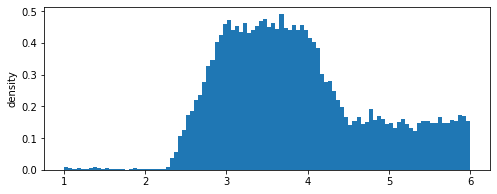

In [73]:
from dmLib import Distribution # Import the arbitrary distribution class

# Behaviour and capability

behaviour = Distribution(aggregate,lb=lb[-1],ub=ub[-1])

print(behaviour(10000).mean(axis=1)) # should be close to 10.0
print(behaviour(10000).std(axis=1)) # should be close to 5.0
behaviour.view()

We embed this stochastic model in `Behaviour` object for the MAN

In [74]:
# this is the n_safety model
class B1(Behaviour):
    def __call__(self,T1,T2):
        # Compute for given inputs
        sim.reset()
        _,aggregate,_ = sim.compute(np.array([[T1,T2],]), normalize=True)
        behaviour = Distribution(aggregate,lb=lb[-1],ub=ub[-1])
        self.target_threshold = behaviour()

b1 = B1('B1')
behaviours = [b1,]

### Margin Nodes
Now we define the margin node. Since $n_\textrm{safety} \ge n_\textrm{safety}^{decided}$, this is a `must_exceed` type of margin

In [75]:
# Defining a MarginNode object
e1 = MarginNode('E1',type='must_exceed')
margin_nodes = [e1,]

### Margin Analysis Network
Now we define how all the previous elements are connected together inside a MAN

In [76]:
# Defining a MarginNetwork object
class MAN(MarginNetwork):
    
    def randomize(self):
        Requirement()
        decided_safety()
        s1();s2();s3()
        
    def forward(self):

        Requirement()
        threshold()

        # retrieve MAN components
        s1 = self.input_specs[0] # stochastic
        s2 = self.input_specs[1] # stochastic
        s3 = self.input_specs[2] # stochastic
        b1 = self.behaviours[0]
        e1 = self.margin_nodes[0]

        # Execute behaviour models
        b1(s1.value,s2.value)
        e1(b1.target_threshold,s3.value)

man = MAN([],input_specs,[],behaviours,margin_nodes,'MAN_1')

## Running the MAN inside a Monte-Carlo simulation
We loop over the defined MarginNetwork object as many times as needed to get the distribution of the margin node

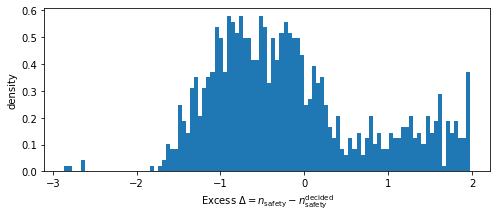

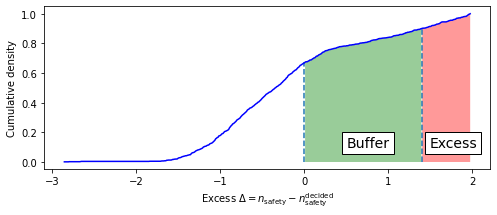

In [77]:
for n in range(1000):
    man.forward()

e1.view(xlabel='Excess $\Delta = n_\mathrm{safety} - \
    n_\mathrm{safety}^\mathrm{decided}$')
e1.view_cdf(xlabel='Excess $\Delta = n_\mathrm{safety} - \
    n_\mathrm{safety}^\mathrm{decided}$')